Example 6.6: Cliff Walking

Sutton Book

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

''' the world '''
WORLD_WIDTH = 12
WORLD_HEIGHT = 4

''' rules '''
START_STATE = (0, 0)
GOAL_STATE = (WORLD_WIDTH-1, 0)

''' actions '''
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

''' policy '''
ALPHA = 0.5
GAMMA = 1

next_state_lookup_table = dict()
def get_next_state_and_reward(state, action):
    ''' look up the next state and reward given current state and action '''
    
    reward = -1.0
    if state not in next_state_lookup_table:
        next_state_lookup_table[state] = dict()
        
    if action not in next_state_lookup_table[state]:
        x, y = state
        if action == ACTION_UP:
            next_state = (x, min(y+1, WORLD_HEIGHT-1))
        if action == ACTION_DOWN:
            next_state = (x, max(y-1, 0))
        if action == ACTION_LEFT:
            next_state = (max(x-1, 0), y)
        if action == ACTION_RIGHT:
            next_state = (min(x+1, WORLD_WIDTH-1), y)
        
        if (1 <= next_state[0] and next_state[0] <= WORLD_WIDTH-2) and next_state[1] == 0:
            next_state = START_STATE
            reward = -100.0
            
        next_state_lookup_table[state][action] = next_state
        
    return next_state_lookup_table[state][action], reward


def one_episode_sarsa(Q, EPSILON):
    timesteps = 0
    trajectory = {}
    sum_of_rewards = 0
    
    # init state
    state = START_STATE
    
    # choose an action using policy derived from Q (ϵ-greedy)
    if np.random.rand() < EPSILON:
        action = np.random.choice(ACTIONS)
    else:
        action = np.argmax(Q[state[0], state[1], :])
        
    while state != GOAL_STATE:
        # take action, and observer next_state, reward
        next_state, reward = get_next_state_and_reward(state, action)
        sum_of_rewards += reward
        
        # choose the next action using policy derived from Q (ϵ-greedy)
        if np.random.rand() < EPSILON:
            next_action = np.random.choice(ACTIONS)
        else:
            next_action = np.argmax(Q[next_state[0], next_state[1], :]) 
        
        # update Q
        Q[state[0], state[1], action] += ALPHA * \
            (reward + GAMMA * Q[next_state[0], next_state[1], next_action] - Q[state[0], state[1], action])
        timesteps += 1
        
        trajectory[state] = action
        state = next_state
        action = next_action
        
    
    return timesteps, trajectory, sum_of_rewards


def one_episode_q_learning(Q, EPSILON):
    timesteps = 0
    trajectory = {}
    sum_of_rewards = 0
    
    # init state
    state = START_STATE
      
    while state != GOAL_STATE:
        # choose an action using policy derived from Q (ϵ-greedy)
        if np.random.rand() < EPSILON:
            action = np.random.choice(ACTIONS)
        else:
            action = np.argmax(Q[state[0], state[1], :])
        
        # take action, and observer next_state, reward
        next_state, reward = get_next_state_and_reward(state, action)
        sum_of_rewards += reward
        
        # update Q
        Q[state[0], state[1], action] += ALPHA * \
            (reward + GAMMA * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])
        timesteps += 1
            
        trajectory[state] = action
        state = next_state
    
    return timesteps, trajectory, sum_of_rewards


def print_trajectory(trajectory):
    table = []
    for y in range(WORLD_HEIGHT-1, -1, -1):
        table.append([])
        for x in range(0, WORLD_WIDTH):
            state = (x, y)
            if state == GOAL_STATE:
                table[-1].append('G')
                continue
                
            if (1 <= x and x <= WORLD_WIDTH-2) and y == 0:
                table[-1].append('■■■■')
            elif state in trajectory:
                action = trajectory[state]
                if action == ACTION_UP:
                    table[-1].append('↑')
                elif action == ACTION_DOWN:
                    table[-1].append('↓')
                elif action == ACTION_LEFT:
                    table[-1].append('←')
                elif action == ACTION_RIGHT:
                    table[-1].append('→')
            else:
                table[-1].append('*')
                
    for row in table:
        for ch in row:
            print(ch, end="\t")
        print()


def test(method='sarsa', EPSILON=0.5):
    # reset Q
    Q = np.zeros((WORLD_WIDTH, WORLD_HEIGHT, 4)) # state-action pair values
    
    n_episode = 500
    ep = 0
    episodes = []
    sums_of_rewards = []
    while ep < n_episode:
        if method == 'sarsa':
            time, trajectory, sum_of_rewards = one_episode_sarsa(Q, EPSILON)
        elif method == 'q-learning':
            time, trajectory, sum_of_rewards = one_episode_q_learning(Q, EPSILON)
        episodes.extend([ep] * time)
        sums_of_rewards.append(sum_of_rewards)
        ep += 1
    
    print('method: %s\n' % method) 
    print('>>>> trajectory of the latest episode')
    print_trajectory(trajectory)
    print('\n')
    
    # print the optimal policy
    print('>>>> optimal policy\n') 
    optimal_policy = dict()
    for y in range(WORLD_HEIGHT-1, -1, -1):
        for x in range(0, WORLD_WIDTH):
            state = (x, y)
            if state != GOAL_STATE:
                best_action = np.argmax(Q[x, y, :])
                optimal_policy[state] = best_action
    print_trajectory(optimal_policy)
    print('\n\n')
    
    return episodes, sums_of_rewards


def plot_figures(episodes_sarsa, sums_of_rewards_sarsa, 
                 episodes_q_learning, sums_of_rewards_q_learning):
    plt.figure()
    plt.plot(range(len(episodes_sarsa)), episodes_sarsa, label='sarsa', color='red')
    plt.plot(range(len(episodes_q_learning)), episodes_q_learning, label='q-learning', color='blue')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('episodes vs timesteps')
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.show()


    smoothed_sums_sarsa = []
    for i in xrange(10, len(sums_of_rewards_sarsa)):
        smoothed_sums_sarsa.append(np.average(sums_of_rewards_sarsa[i:i+10]))

    smoothed_sums_q_learning = []
    for i in xrange(10, len(sums_of_rewards_q_learning)):
        smoothed_sums_q_learning.append(np.average(sums_of_rewards_q_learning[i:i+10]))

    plt.figure()
    plt.plot(range(len(smoothed_sums_sarsa)), smoothed_sums_sarsa, label='sarsa', color='red')
    plt.plot(range(len(smoothed_sums_q_learning)), smoothed_sums_q_learning, label='q-learning', color='blue')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('sum of rewards')
    plt.xlabel('Episodes')
    plt.ylabel('sum of rewards')
    plt.show()

def test_different_epsilon(EPSILON):
    print('*'*30)
    print('epsilon: %s' % EPSILON)
    print('*'*30)
    print()
    print()
    episodes_sarsa, sums_of_rewards_sarsa = test(method='sarsa', EPSILON=EPSILON)  
    episodes_q_learning, sums_of_rewards_q_learning = test(method='q-learning', EPSILON=EPSILON)
    plot_figures(episodes_sarsa, sums_of_rewards_sarsa, \
                     episodes_q_learning, sums_of_rewards_q_learning)

******************************
epsilon: 0.5
******************************


method: sarsa

>>>> trajectory of the latest episode
*	→	→	→	→	→	→	→	↓	*	*	*	
*	↑	←	*	*	*	*	↓	↓	*	*	*	
→	↑	*	*	*	*	*	→	→	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	


>>>> optimal policy

→	↓	→	→	→	→	→	→	→	→	↓	↓	
→	→	→	→	↑	↑	↑	→	↑	→	→	↓	
→	↑	↑	↑	↑	↑	↑	→	→	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	



method: q-learning

>>>> trajectory of the latest episode
*	→	↓	*	*	*	*	*	*	*	*	*	
↓	↑	↓	←	*	*	*	*	*	*	*	*	
→	→	→	→	→	→	→	→	→	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	


>>>> optimal policy

↓	↓	↓	↓	↓	↓	↓	↓	↓	↓	↓	↓	
↓	↓	↓	↓	↓	↓	↓	↓	↓	↓	↓	↓	
→	→	→	→	→	→	→	→	→	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	





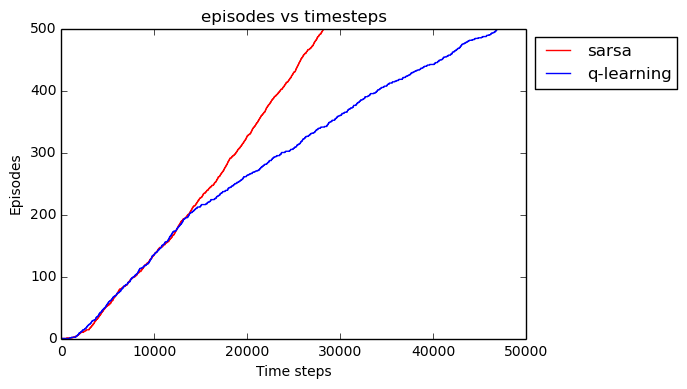

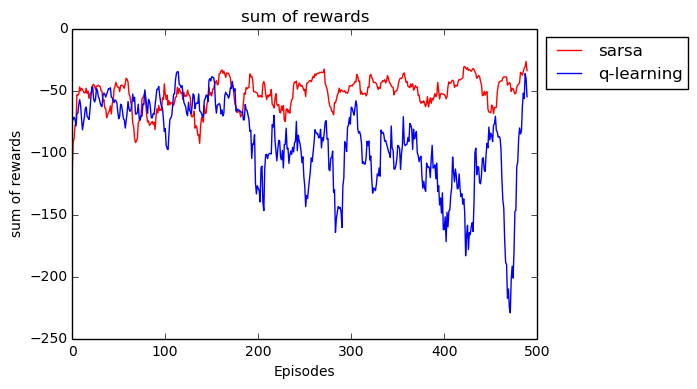

In [2]:
test_different_epsilon(EPSILON=.5)

******************************
epsilon: 0.05
******************************


method: sarsa

>>>> trajectory of the latest episode
*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	→	↓	*	*	
→	→	→	→	→	→	→	→	↑	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	


>>>> optimal policy

→	→	→	→	→	→	→	→	→	→	↓	↓	
→	→	→	→	→	→	→	→	→	↓	↓	↓	
→	→	→	→	→	→	→	→	↑	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	



method: q-learning

>>>> trajectory of the latest episode
*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	↓	*	*	*	
→	→	→	→	→	→	→	→	→	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	


>>>> optimal policy

→	→	↑	→	↑	→	→	↑	→	→	→	↓	
→	←	↓	→	→	→	→	↓	→	↓	→	↓	
→	→	→	→	→	→	→	→	→	→	→	↓	
↑	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	■■■■	G	





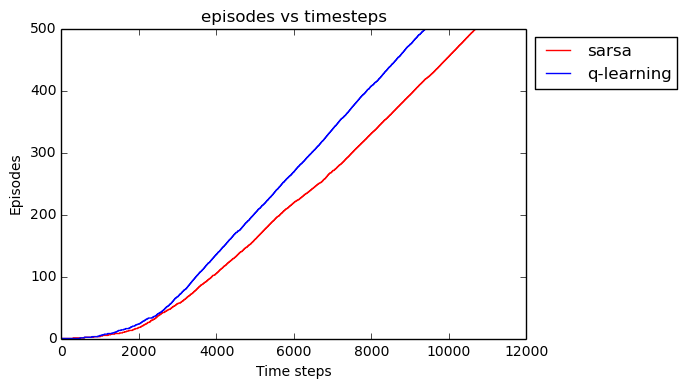

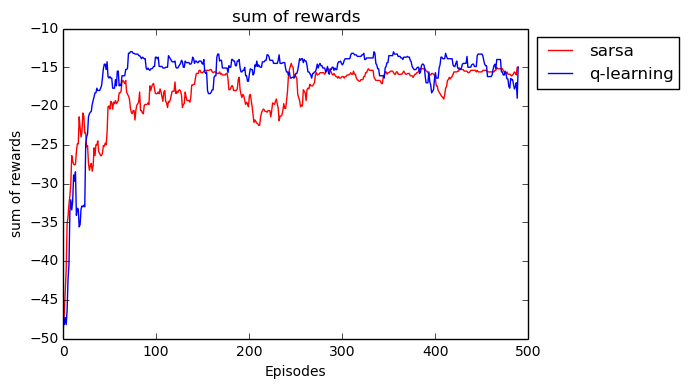

In [3]:
test_different_epsilon(EPSILON=.05)